In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras import Sequential
import matplotlib.pyplot as plt


In [2]:
import os
import random
from tqdm import tqdm

In [3]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
# fc layers are called Dense in keras; flatten multidim vector to single dim vector

## LOADING THE DATASET
(1000 CAT IMGS & 1000 DOG IMGS)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d bhavikjikadara/dog-and-cat-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset
License(s): apache-2.0


In [7]:
!unzip -q dog-and-cat-classification-dataset.zip -d ./data


In [8]:
import os

for root, dirs, files in os.walk('./data'):
    print(root)
    if 'Cat' in dirs or 'Dog' in dirs:
        break


./data
./data/PetImages


In [9]:

import cv2
# Define paths
cat_dir = "./data/PetImages/Cat"
dog_dir = "./data/PetImages/Dog"

# Helper function to load valid images
def load_images(folder, label, count):
    images = []
    labels = []
    files = [f for f in os.listdir(folder) if f.endswith('.jpg')]
    random.shuffle(files)
    loaded = 0

    for img_name in tqdm(files, desc=f"Loading {folder}"):
        if loaded >= count:
            break
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is not None and len(img.shape) == 3:  # RGB check
            images.append(img)
            labels.append(label)
            loaded += 1
    print(f"✅ Loaded {loaded} images from {folder}")
    return images, labels

# Load 1000 for training, 200 for testing per class
cat_train_imgs, cat_train_labels = load_images(cat_dir, 0, 1000)
dog_train_imgs, dog_train_labels = load_images(dog_dir, 1, 1000)
cat_test_imgs, cat_test_labels = load_images(cat_dir, 0, 200)
dog_test_imgs, dog_test_labels = load_images(dog_dir, 1, 200)

# Combine and resize to (100, 100)
def preprocess(images):
    return [cv2.resize(img, (100, 100)) for img in images]

X_train = np.array(preprocess(cat_train_imgs + dog_train_imgs))
Y_train = np.array(cat_train_labels + dog_train_labels).reshape(-1, 1)

X_test = np.array(preprocess(cat_test_imgs + dog_test_imgs))
Y_test = np.array(cat_test_labels + dog_test_labels).reshape(-1, 1)

print("✅ Shapes:")
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)


Loading ./data/PetImages/Cat:   8%|▊         | 1003/12499 [00:01<00:16, 708.94it/s]


✅ Loaded 1000 images from ./data/PetImages/Cat


Loading ./data/PetImages/Dog:   8%|▊         | 1001/12499 [00:01<00:16, 680.31it/s]


✅ Loaded 1000 images from ./data/PetImages/Dog


Loading ./data/PetImages/Cat:   2%|▏         | 200/12499 [00:00<00:16, 724.88it/s]


✅ Loaded 200 images from ./data/PetImages/Cat


Loading ./data/PetImages/Dog:   2%|▏         | 200/12499 [00:00<00:17, 689.10it/s]


✅ Loaded 200 images from ./data/PetImages/Dog
✅ Shapes:
X_train: (2000, 100, 100, 3)
Y_train: (2000, 1)
X_test: (400, 100, 100, 3)
Y_test: (400, 1)


img pixel values range from 0 to 255 but for training we need to normalise them.

In [10]:
X_train = X_train/255.0
X_test = X_test/255.0

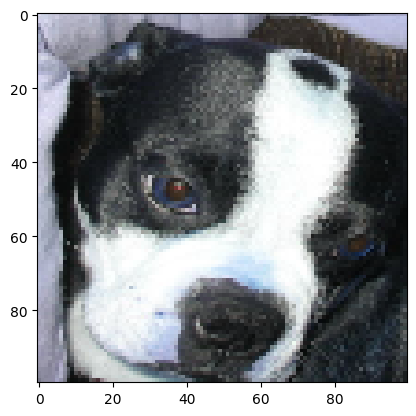

In [11]:
idx = random.randint(0, len(X_train))
plt.imshow(X_train[idx, :])
plt.show()

In [12]:
model = Sequential([
    Conv2D(32, (3,3), activation = 'relu', input_shape = (100,100,3)), # for 1st layer, we hv mentioned no. of filters, size of each, act fn, ip shape for 1st layer
    MaxPooling2D((2,2)), #stride is taken by default
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation = 'relu'), #Dense = fc layer; 1st fc layer w/ 64 neurons
    Dense(1, activation = 'sigmoid'), #final fc layer/output layer; shld hv same no. of neurons as op class
    #since it's binary classification there'll be only 1 neuron and act fn is sigmoid
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# another way of defining the model
model = Sequential()
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (100,100,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add( MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [14]:
# model will be compiled by adding backprop and loss fn
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # metrics specifies the metric on which we'll be evaluating our model

another way to specify optimiser is:
opt = keras.optimizers.SGD(learning_rate = 0.001)

there can b different types of optimisers, their hyperparameters and loss fns


now we need to fit training data into our model

if model is not compiled, running below cell again would resume training frm where it left. But since it's compiled it will restart training.

In [16]:
 model.fit(X_train,Y_train, epochs = 5, batch_size=64)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 641ms/step - accuracy: 0.8441 - loss: 0.3762
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 602ms/step - accuracy: 0.8699 - loss: 0.3072
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 641ms/step - accuracy: 0.9046 - loss: 0.2555
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 604ms/step - accuracy: 0.9402 - loss: 0.1879
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 638ms/step - accuracy: 0.9465 - loss: 0.1606


In [17]:
model.evaluate(X_test, Y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7723 - loss: 0.6537


[0.6743576526641846, 0.7450000047683716]

## MAKING PREDICTIONS

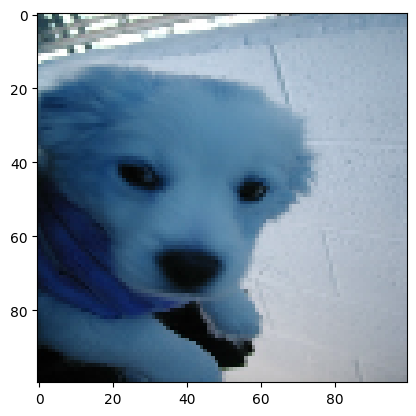

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
this is a  dog


In [20]:
idx2 = random.randint(0, len(Y_test))
plt.imshow(X_test[idx2, :])
plt.show()

y_pred = model.predict(X_test[idx2, :].reshape(1,100,100,3))
y_pred=y_pred>0.5

if(y_pred == 0):
  pred = 'cat'
else:
  pred = 'dog'

print("this is a ",pred)